In [ ]:

# Mount Google Drive (if using)
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies (if needed)
!pip install shap optuna

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/SM technology/health_data_10000_chunk.csv')

# **EDA**

Columns in dataset: ['Height (cm)', 'Weight (kg)', 'BMI', 'Medical conditions', 'Medications in use', 'Residential Address', 'Previous gastrointestinal issues', 'Family history of diseases', 'Previous surgeries', 'Previous therapies', 'Frequency of bowel movements', 'Stool consistency (Bristol scale)', 'Presence of bloating', 'Presence of gas', 'Presence of abdominal pain', 'Difficult digestion', 'Known intolerances', 'Food allergies', 'Current diet', 'Weekly consumption of vegetables (portions)', 'Weekly consumption of fruits (portions)', 'Weekly consumption of whole grains (portions)', 'Weekly consumption of animal proteins (portions)', 'Weekly consumption of plant proteins (portions)', 'Weekly consumption of dairy products (portions)', 'Weekly consumption of fermented foods (portions)', 'Daily water intake (liters)', 'Alcohol consumption', 'Meal times', 'Physical activity type', 'Weekly frequency of physical activity (per week)', 'Average sleep hours (hours)', 'Stress level (1-10 sc

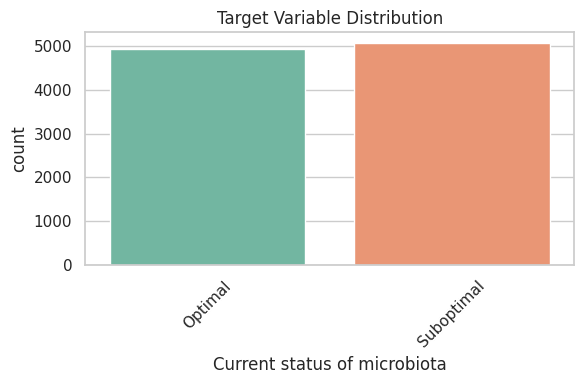

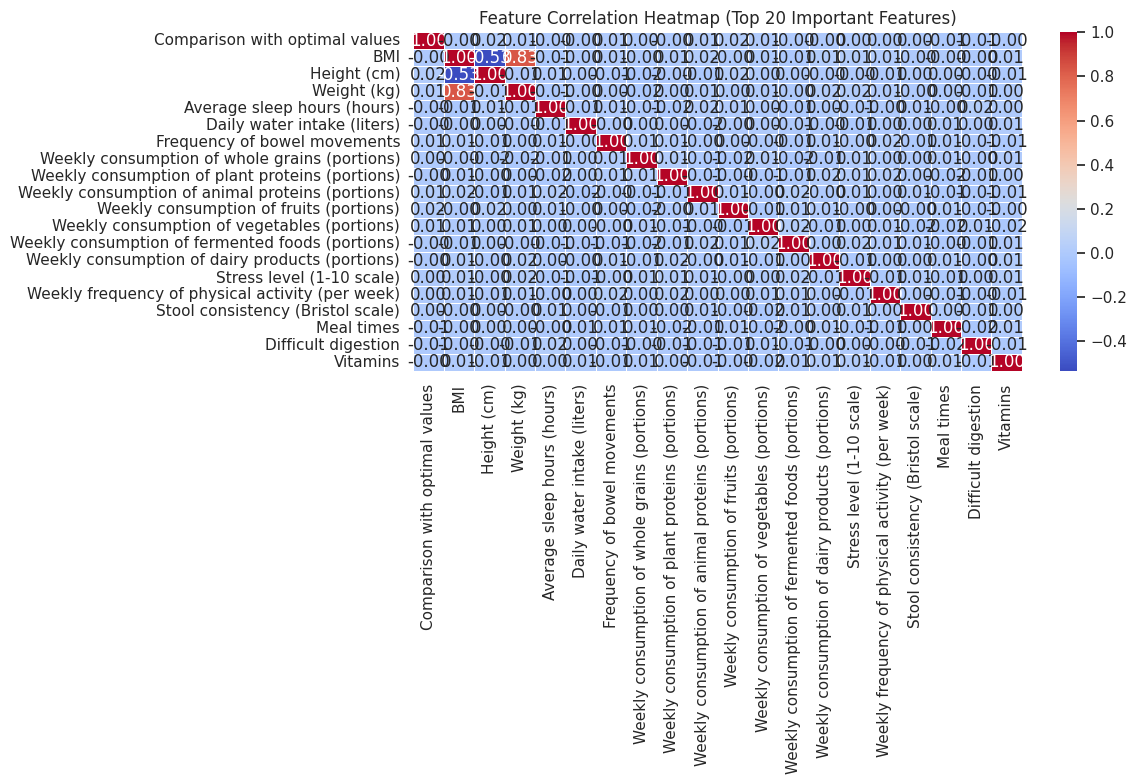

Missing values:
 Series([], dtype: int64)


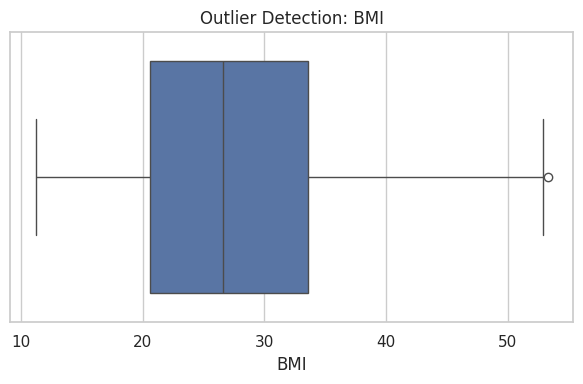


Class distribution:
                               Count  Percentage
Current status of microbiota                   
Suboptimal                     5058       50.58
Optimal                        4942       49.42


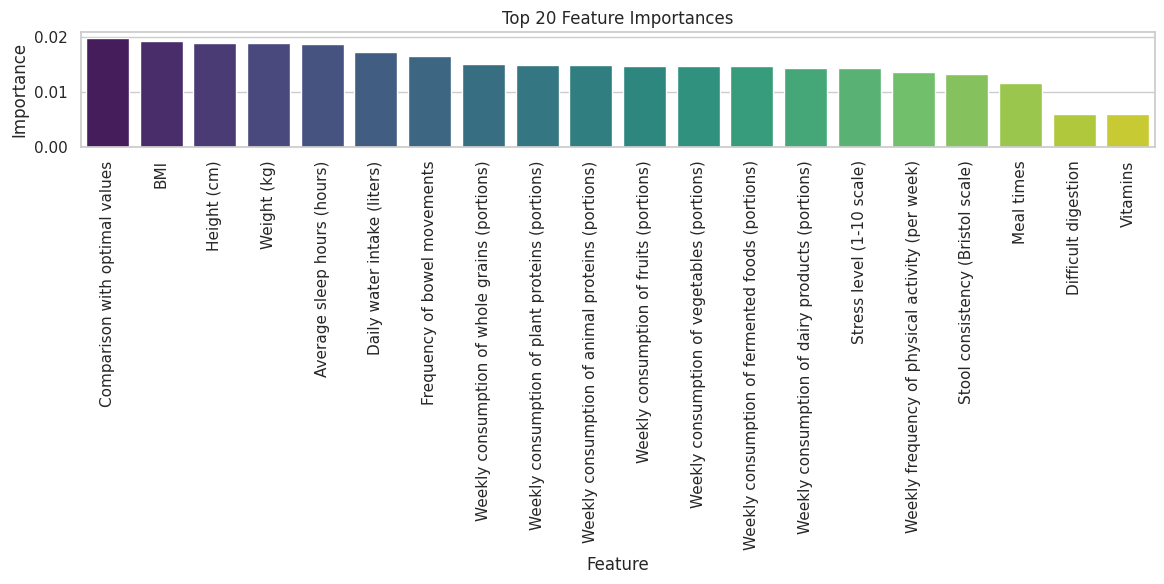

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()

print("Columns in dataset:", df.columns.tolist())

# Define target column
target_col = 'Current status of microbiota'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

# 1. Visualize target distribution
# -----------------------------
target_col = 'Current status of microbiota'
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x=target_col, palette='Set2')
plt.title('Target Variable Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -----------------------------
# 2. Feature Correlation
# -----------------------------
# 1. Feature Selection - Identify Important Features
# -----------------------------

# One-hot encode categorical columns (excluding the target column)
df_encoded = pd.get_dummies(df.drop(columns=[target_col]), drop_first=True)

# Define target variable (assuming it's categorical)
y = df[target_col]
if y.dtype == 'object':
    y = pd.factorize(y)[0]

# Split data for feature selection
X = df_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model to determine feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Select top N important features (e.g., top 20)
top_n = 20
important_features = feature_importances.head(top_n)['Feature']

# -----------------------------
# 2. Feature Correlation (Only Important Features)
# -----------------------------

# Subset data to keep only the important features
df_important = df_encoded[important_features]

# Create the correlation matrix for the important features
correlation_matrix = df_important.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title(f'Feature Correlation Heatmap (Top {top_n} Important Features)')
plt.tight_layout()
plt.show()



# -----------------------------
# 3. Missing Values and Outliers
# -----------------------------
# Missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Outlier detection (e.g., for BMI)
if 'BMI' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='BMI')
    plt.title('Outlier Detection: BMI')
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Class Imbalance
# -----------------------------
class_counts = df[target_col].value_counts()
class_percent = class_counts / len(df) * 100
print("\nClass distribution:\n", pd.concat([class_counts, class_percent], axis=1, keys=['Count', 'Percentage']))

# -----------------------------
# 5. Feature Importance using Random Forest
# -----------------------------

# Handle multi-label text fields (example: 'Medical Conditions')
if 'Medical Conditions' in df.columns:
    multi = df['Medical Conditions'].fillna('').str.get_dummies(sep=',')
    multi.columns = [col.strip() for col in multi.columns]
    df = df.drop('Medical Conditions', axis=1)
    df = pd.concat([df, multi], axis=1)

# Separate target
y = df[target_col]
X = df.drop(columns=[target_col])

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Encode target if it's categorical
if y.dtype == 'object':
    y = pd.factorize(y)[0]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp.head(20), x='Feature', y='Importance', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# **Data Preprocessing**

In [ ]:
# -----------------------------
# 1. Handle Missing Values
# -----------------------------
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill missing numerical values with median

# -----------------------------
# 2. Encode Categorical Variables
# -----------------------------
# Encode categorical features (except target)
for col in df.select_dtypes(include='object'):
    if col != 'Current status of microbiota':  # Exclude the target variable
        df[col] = LabelEncoder().fit_transform(df[col])

# -----------------------------
# 3. Encode Target Variable
# -----------------------------
df['Current status of microbiota'] = LabelEncoder().fit_transform(df['Current status of microbiota'])

# -----------------------------
# 4. Train-Test Split
# -----------------------------
X = df.drop('Current status of microbiota', axis=1)  # Features
y = df['Current status of microbiota']  # Target

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# -----------------------------
# 5. Handle Class Imbalance with SMOTE
# -----------------------------
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

# -----------------------------
# 6. Standardize the Features
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------------
# Print the data to check if everything is done correctly
# -----------------------------
# Print the first few rows of the processed dataset
print("Processed Data (first few rows):")
print(df.head())

# Check the missing values after filling
print("Missing values after filling:", df.isnull().sum())

# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Optionally, check the class distribution in the target variable after SMOTE
print("Class distribution in y_train after SMOTE:")
print(pd.Series(y_train).value_counts())

Processed Data (first few rows):
   Height (cm)  Weight (kg)   BMI  Medical conditions  Medications in use  \
0          173          120  40.1                  10                   1   
1          183          110  32.8                   5                  12   
2          160          111  43.4                  16                   2   
3          177           75  23.9                   0                  19   
4          170           97  33.6                  16                  13   

   Residential Address  Previous gastrointestinal issues  \
0                 1561                              True   
1                 1033                             False   
2                 8057                             False   
3                 1682                              True   
4                 3679                              True   

   Family history of diseases  Previous surgeries  Previous therapies  \
0                           0                   0                   0 

# **Feature** **Engineering**


In [ ]:

from sklearn.preprocessing import KBinsDiscretizer

# Assuming you already have 'df' loaded and preprocessed from the previous steps

# -----------------------------
# 1. Deriving Composite Metrics
# -----------------------------
# Example: Plant-to-Animal Protein Ratio (assuming 'plant_protein' and 'animal_protein' columns exist)
if 'plant_protein' in df.columns and 'animal_protein' in df.columns:
    df['plant_to_animal_protein_ratio'] = df['plant_protein'] / (df['animal_protein'] + 1e-5)  # Avoid division by zero
    print("Created 'plant_to_animal_protein_ratio' feature.")

# -----------------------------
# 2. Converting Ordinal Data to Bins (e.g., Stress Level)
# -----------------------------
# Let's assume 'stress_level' is an ordinal feature with values like 'Low', 'Medium','AtRisk
if 'stress_level' in df.columns:
    # We will map the ordinal values to a numeric scale and bin them
    stress_mapping = {'LowOptimal': 1, 'Suboptimal': 2, 'AtRisk': 3}
    df['stress_level'] = df['stress_level'].map(stress_mapping)

    # Convert ordinal values to bins
    # Let's bin into 3 categories (Low, Medium, High)
    binning = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    df['stress_level_binned'] = binning.fit_transform(df[['stress_level']])
    print("Created 'stress_level_binned' feature.")

# -----------------------------
# 3. Highlighting Gut Health-Related Features Using Domain Knowledge
# -----------------------------
# For example, let's say 'fiber_intake' and 'probiotic_intake' are gut health-related features.
# We'll create a new column to sum up these features as a 'gut_health_score' (assuming they exist)

if 'fiber_intake' in df.columns and 'probiotic_intake' in df.columns:
    df['gut_health_score'] = df['fiber_intake'] + df['probiotic_intake']
    print("Created 'gut_health_score' feature.")

# -----------------------------
# Print the first few rows to check the new features
# -----------------------------
print("First few rows with new features:")
print(df.head())

# Optionally, check the new features' correlation with the target variable
print("Correlation with target (Current status of microbiota):")
print(df.corr()['Current status of microbiota'])



First few rows with new features:
   Height (cm)  Weight (kg)   BMI  Medical conditions  Medications in use  \
0          173          120  40.1                  10                   1   
1          183          110  32.8                   5                  12   
2          160          111  43.4                  16                   2   
3          177           75  23.9                   0                  19   
4          170           97  33.6                  16                  13   

   Residential Address  Previous gastrointestinal issues  \
0                 1561                              True   
1                 1033                             False   
2                 8057                             False   
3                 1682                              True   
4                 3679                              True   

   Family history of diseases  Previous surgeries  Previous therapies  \
0                           0                   0                   0

#  **Baseline** **Models**

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Train Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

#  Model Evaluation

#  Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.5030


# **Logistic Regression Ealutaion**

Accuracy: 0.5030
Precision: 0.5089
Recall: 0.5089
F1-Score: 0.5089
AUC-ROC: 0.5029


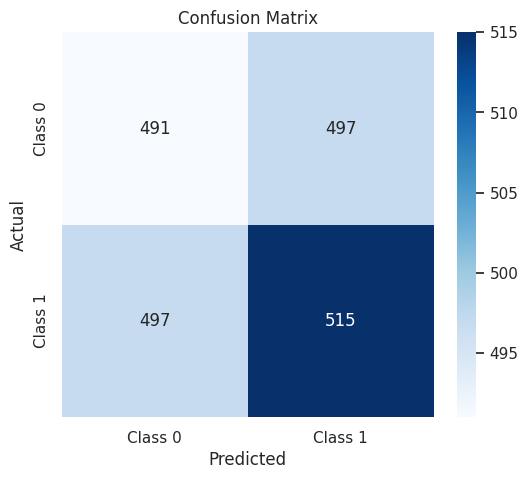

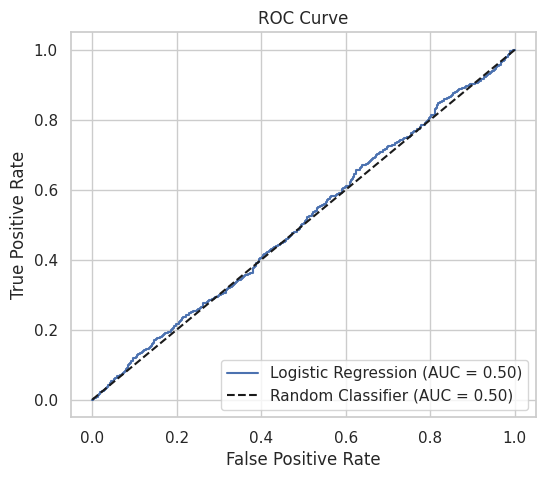

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])  # Getting the probabilities for class 1
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# **Logictic Regression Model Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}

# Grid Search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best Parameters: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))



Best Parameters:  {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Test Accuracy:  0.5075


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Random Forest Model
# -------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)






RandomForestClassifier(random_state=42)

# **Random Forest evaluation**

Random Forest - Accuracy: 0.5075
Random Forest - Precision: 0.5132
Random Forest - Recall: 0.5168
Random Forest - F1-Score: 0.5150
Random Forest - AUC-ROC: 0.5074


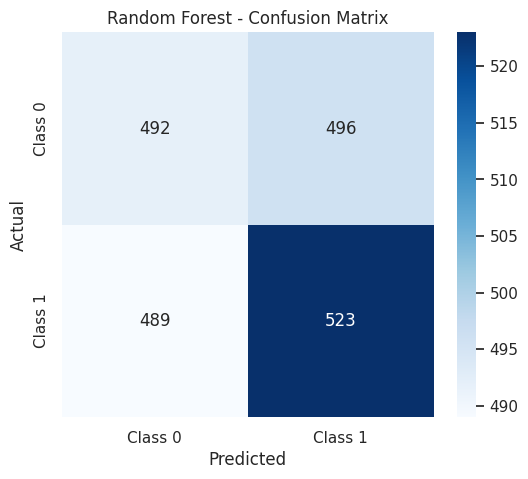

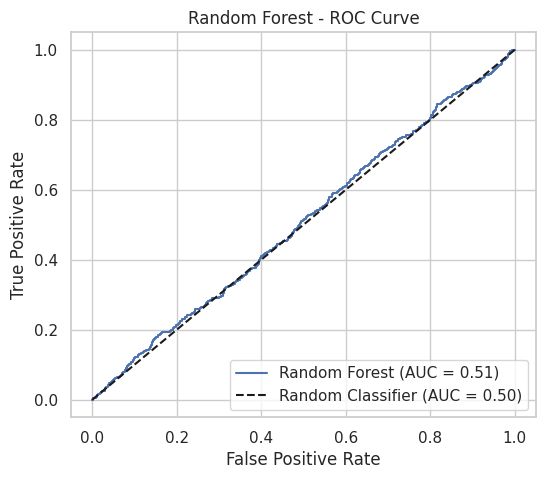

In [ ]:
y_pred_rf = y_pred
# Calculate the evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)

# Display the metrics
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - F1-Score: {f1_rf:.4f}")
print(f"Random Forest - AUC-ROC: {auc_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.title('Random Forest - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# **Random Forest Model** **Tuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Randomized Search with 20 iterations, 5-fold cross-validation, parallel processing
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,         # Use all available cores
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model evaluation
print("Best Parameters: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Test Accuracy:  0.4965


# **XGBoost**

In [ ]:
!pip install xgboost imbalanced-learn


Accuracy: 0.5115

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.52      0.51       988
           1       0.52      0.50      0.51      1012

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000


Confusion Matrix:
 [[514 474]
 [503 509]]


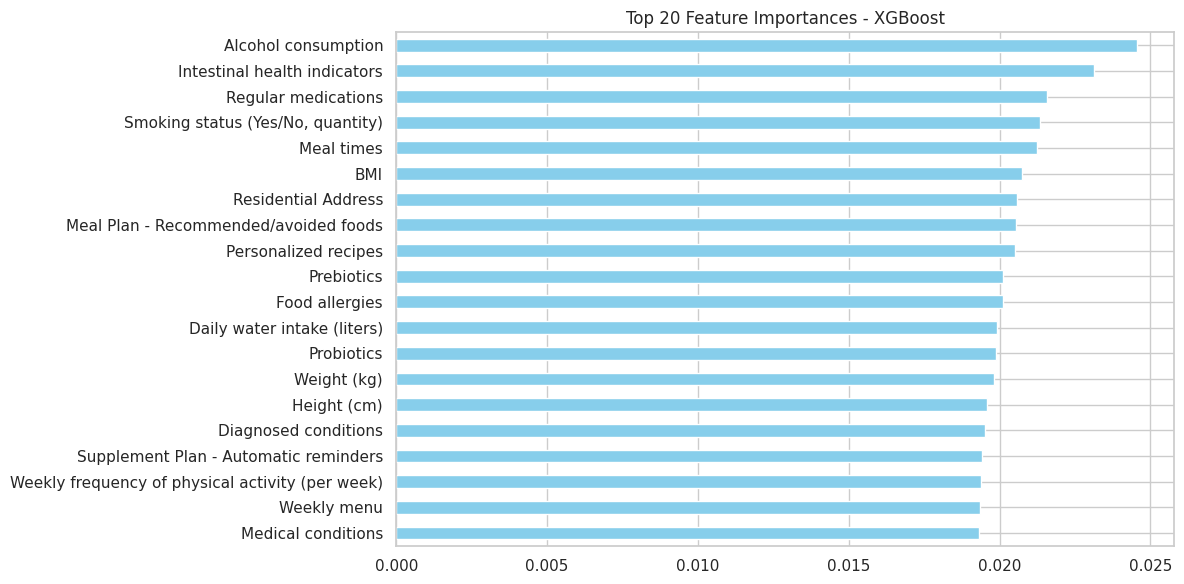

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Plot feature importances
plt.figure(figsize=(12, 6))
importances = pd.Series(xgb.feature_importances_, index=X.columns)
importances.nlargest(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# **XGBoost Evaluation**

XGBoost - Accuracy: 0.5115
XGBoost - Precision: 0.5178
XGBoost - Recall: 0.5030
XGBoost - F1-Score: 0.5103
XGBoost - AUC-ROC: 0.5116


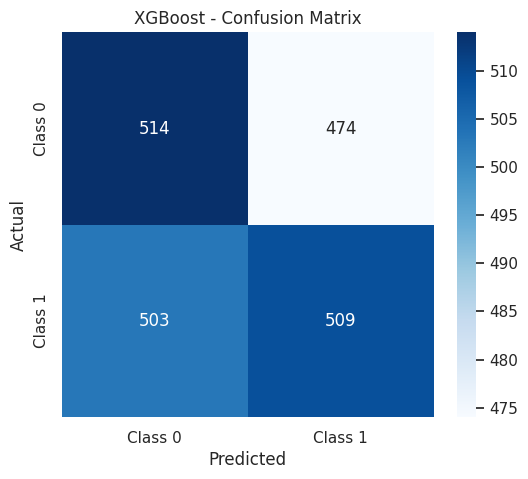

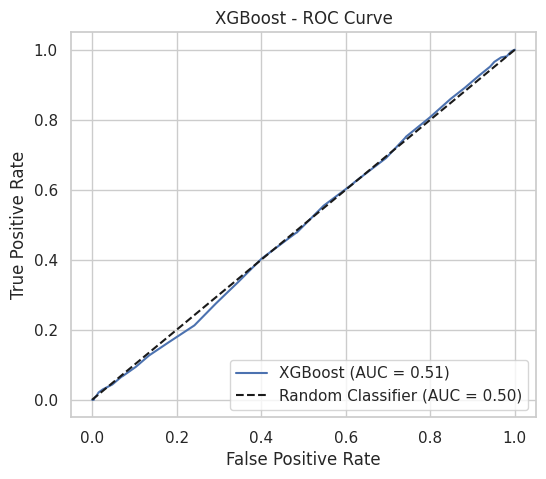

In [ ]:
y_pred_xgb = y_pred
# Calculate the evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Display the metrics
print(f"XGBoost - Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost - Precision: {precision_xgb:.4f}")
print(f"XGBoost - Recall: {recall_xgb:.4f}")
print(f"XGBoost - F1-Score: {f1_xgb:.4f}")
print(f"XGBoost - AUC-ROC: {auc_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.title('XGBoost - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()



# **XGBooast Model tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Reduced parameter space using distributions
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,             # You can reduce to 20 for even faster
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Evaluate best model
print("Best Parameters: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters:  {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Test Accuracy:  0.49


# **Advanced** **Models**

# ANN

In [ ]:
!pip install imbalanced-learn tensorflow



# ANN creation and evalution


Epoch 1/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5068 - loss: 0.7158 - val_accuracy: 0.5133 - val_loss: 0.6927
Epoch 2/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5349 - loss: 0.6942 - val_accuracy: 0.5034 - val_loss: 0.6938
Epoch 3/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5127 - loss: 0.6950 - val_accuracy: 0.5139 - val_loss: 0.6934
Epoch 4/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5132 - loss: 0.6940 - val_accuracy: 0.5176 - val_loss: 0.6935
Epoch 5/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5292 - loss: 0.6920 - val_accuracy: 0.5040 - val_loss: 0.6937
Epoch 6/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5396 - loss: 0.6902 - val_accuracy: 0.5040 - val_loss: 0.6940
Epoch 7/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5417 - loss: 0.6872 - val_accuracy: 0.5127 - val_loss: 0.6940
Epoch 8/60
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5392 - loss: 0.6875 - val_accuracy

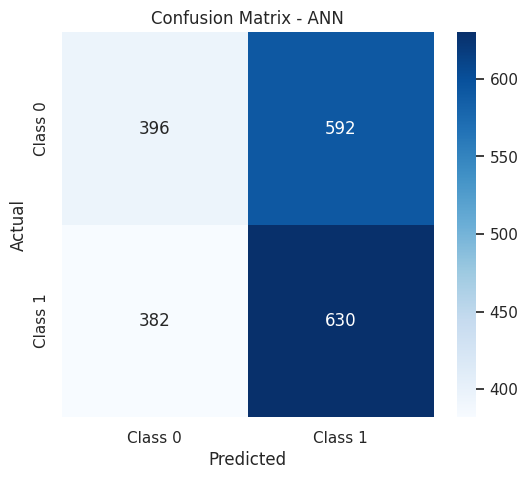

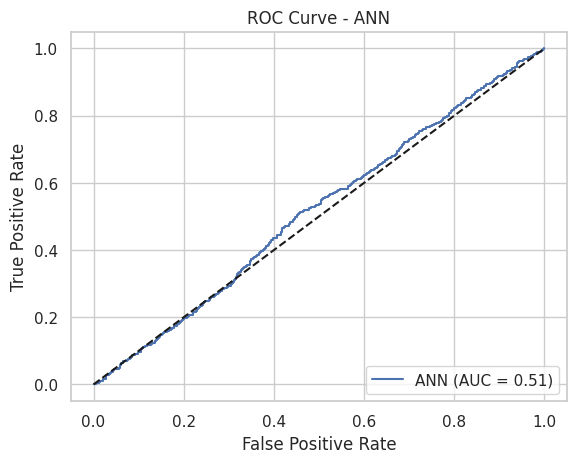

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Convert to correct dtypes
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)
y_test = np.array(y_test).astype(np.int32)

# Build ANN model for binary classification
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary output

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype("int32")

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nANN Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - ANN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ANN (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **ANN model tuning**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Parameter distribution
param_dist = {
    'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# MLPClassifier with controlled iterations
mlp = MLPClassifier(max_iter=300, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=15,         # Try fewer iterations to speed up (e.g., 10–15)
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Evaluate
print("Best Parameters: ", random_search.best_params_)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50, 50), 'activation': 'relu'}
Test Accuracy:  0.513


# LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# -----------------------------
# 1. Train LightGBM Classifier
# -----------------------------
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    class_weight='balanced'  # helps with imbalanced classes
)

lgbm_model.fit(X_train, y_train)



[LightGBM] [Info] Number of positive: 4046, number of negative: 4046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 8092, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, random_state=42)

# **LightGBM Evaluation**



LightGBM Evaluation Metrics:
Accuracy:  0.5130
Precision: 0.5188
Recall:    0.5168
F1-score:  0.5178
AUC-ROC:   0.5146


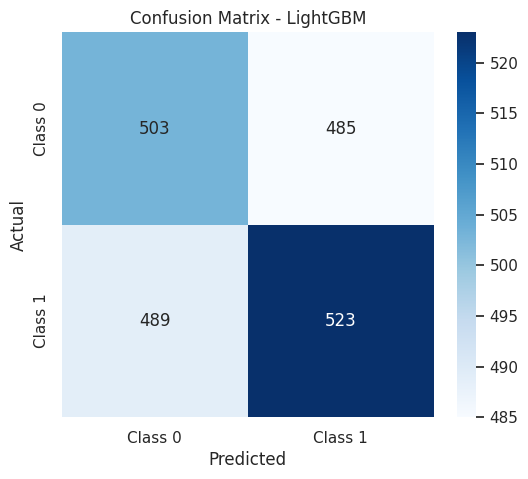

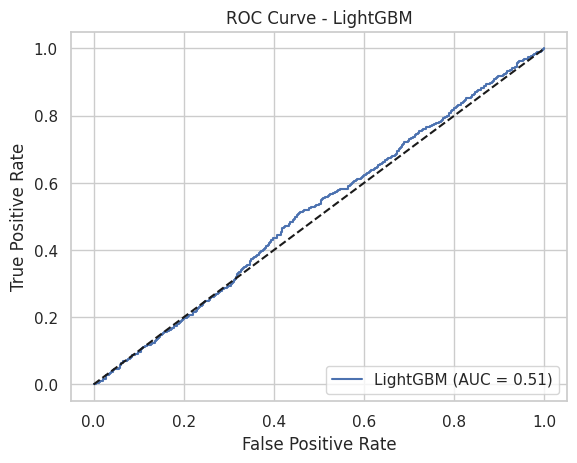

In [ ]:


from lightgbm import LGBMClassifier

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"\nLightGBM Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **LightGBM Model Tuning**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

# Define model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20],
    'num_leaves': [31, 50],
    'reg_alpha': [0, 0.1],  # L1 regularization
    'reg_lambda': [0, 0.1], # L2 regularization
}

# Grid search
grid_search = GridSearchCV(lgb_model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model & prediction
best_lgbm = grid_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_lgbm)))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[LightGBM] [Info] Number of positive: 4046, number of negative: 4046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 8092, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 0}
Test Accuracy: 0.4865

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49       988
           1       0.49      0.47      0.48      1012

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49

# **Transformer**-**Based** **Model**

# TabNet


In [ ]:
!pip install pytorch-tabnet


In [ ]:

from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# -----------------------------
#  Convert to NumPy Arrays
# -----------------------------
X_train_np = X_train_scaled.astype(np.float32)
X_test_np = X_test_scaled.astype(np.float32)
y_train_np = y_train.astype(int)
y_test_np = y_test.astype(int)


# -----------------------------
# Train TabNet Classifier
# -----------------------------
clf = TabNetClassifier(verbose=1, seed=42)

clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
)

# -----------------------------
#  Evaluate Model
# -----------------------------
y_pred = clf.predict(X_test_np)
acc = accuracy_score(y_test_np, y_pred)
print("\n✅ Accuracy:", acc)
print("\n📊 Classification Report:\n", classification_report(y_test_np, y_pred))


epoch 0  | loss: 0.75388 | test_accuracy: 0.488   |  0:00:00s
epoch 1  | loss: 0.7013  | test_accuracy: 0.5025  |  0:00:01s
epoch 2  | loss: 0.69666 | test_accuracy: 0.509   |  0:00:01s
epoch 3  | loss: 0.69325 | test_accuracy: 0.517   |  0:00:02s
epoch 4  | loss: 0.69312 | test_accuracy: 0.5085  |  0:00:02s
epoch 5  | loss: 0.69258 | test_accuracy: 0.4975  |  0:00:03s
epoch 6  | loss: 0.6926  | test_accuracy: 0.506   |  0:00:03s
epoch 7  | loss: 0.69148 | test_accuracy: 0.506   |  0:00:04s
epoch 8  | loss: 0.69183 | test_accuracy: 0.5     |  0:00:04s
epoch 9  | loss: 0.69186 | test_accuracy: 0.4795  |  0:00:05s
epoch 10 | loss: 0.69053 | test_accuracy: 0.499   |  0:00:05s
epoch 11 | loss: 0.69017 | test_accuracy: 0.506   |  0:00:06s
epoch 12 | loss: 0.69028 | test_accuracy: 0.5     |  0:00:06s
epoch 13 | loss: 0.68758 | test_accuracy: 0.4955  |  0:00:07s
epoch 14 | loss: 0.68851 | test_accuracy: 0.5     |  0:00:07s
epoch 15 | loss: 0.68966 | test_accuracy: 0.513   |  0:00:08s
epoch 16

# **TabNet Evaluation**



TabNet Evaluation Metrics:
Accuracy:  0.5170
Precision: 0.5171
Recall:    0.6868
F1-score:  0.5900
AUC-ROC:   0.5146


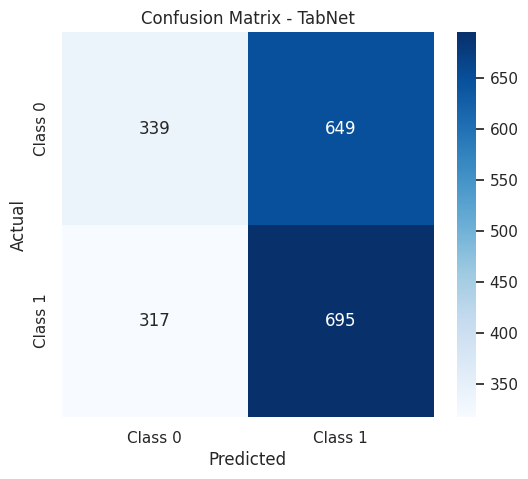

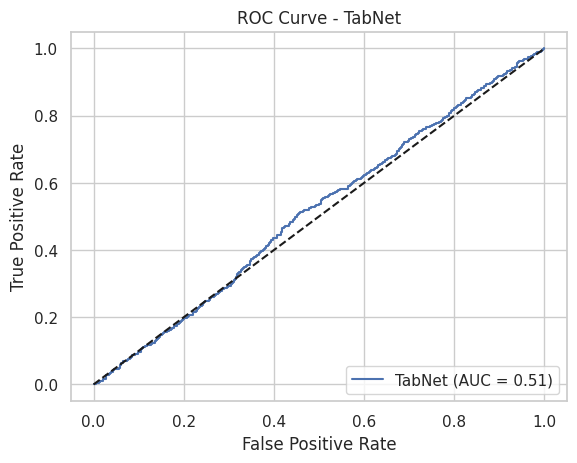

In [ ]:



# Evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred)
recall = recall_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
auc = roc_auc_score(y_test_np, y_pred_proba)

# Print metrics
print(f"\nTabNet Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - TabNet')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, y_pred_proba)
plt.plot(fpr, tpr, label=f'TabNet (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - TabNet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# **TabNet Model Tuning**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
import torch

# Optional: Fix random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# -----------------------------
# Data Preparation
# -----------------------------
# Replace with your actual dataset
# Assume you already have: X_train, X_test, y_train, y_test

# Convert to NumPy arrays if needed
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Train/Validation split for Optuna
X_tr, X_val, y_tr, y_val = train_test_split(X_train_np, y_train_np, test_size=0.2, random_state=42)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# Optuna Objective Function
# -----------------------------
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-3, 1e-1)},
        "seed": 42,
        "verbose": 0,
        "device_name": device
    }

    model = TabNetClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128
    )

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc

# -----------------------------
# Run Optuna
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

# -----------------------------
# Train Final Model
# -----------------------------
best_params = study.best_trial.params.copy()
lr = best_params.pop("lr")  # Remove lr from top level
best_params["optimizer_params"] = {"lr": lr}
best_params["device_name"] = device
best_params["seed"] = 42
best_params["verbose"] = 0

final_model = TabNetClassifier(**best_params)
final_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=512,
    virtual_batch_size=128
)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = final_model.predict(X_test_np)
acc = accuracy_score(y_test_np, y_pred)
print("\n✅ Test Accuracy:", acc)


[I 2025-05-14 19:25:11,513] A new study created in memory with name: no-name-953f4553-700d-4281-8f97-f06688f0426d



Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_accuracy = 0.52502


[I 2025-05-14 19:26:02,695] Trial 0 finished with value: 0.5250154416306362 and parameters: {'n_d': 8, 'n_a': 59, 'n_steps': 7, 'gamma': 1.604783924949646, 'lambda_sparse': 0.0007377886569533245, 'lr': 0.03704660261118346}. Best is trial 0 with value: 0.5250154416306362.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_accuracy = 0.53552


[I 2025-05-14 19:26:31,898] Trial 1 finished with value: 0.535515750463249 and parameters: {'n_d': 23, 'n_a': 32, 'n_steps': 4, 'gamma': 1.3772888306809175, 'lambda_sparse': 0.0009713234107374057, 'lr': 0.03170772062279519}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_accuracy = 0.52502


[I 2025-05-14 19:28:03,161] Trial 2 finished with value: 0.5250154416306362 and parameters: {'n_d': 61, 'n_a': 51, 'n_steps': 8, 'gamma': 1.2962656716250702, 'lambda_sparse': 0.0005794927867103568, 'lr': 0.09812803053882777}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_accuracy = 0.52378


[I 2025-05-14 19:28:42,183] Trial 3 finished with value: 0.5237801111797405 and parameters: {'n_d': 49, 'n_a': 37, 'n_steps': 6, 'gamma': 1.5479165085657804, 'lambda_sparse': 0.0009583831752160673, 'lr': 0.04829842826160154}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_accuracy = 0.53366


[I 2025-05-14 19:29:31,005] Trial 4 finished with value: 0.5336627547869055 and parameters: {'n_d': 55, 'n_a': 38, 'n_steps': 7, 'gamma': 1.526360797534268, 'lambda_sparse': 0.0004822296872418672, 'lr': 0.06105203708410745}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_accuracy = 0.51884


[I 2025-05-14 19:30:14,650] Trial 5 finished with value: 0.5188387893761581 and parameters: {'n_d': 43, 'n_a': 10, 'n_steps': 9, 'gamma': 1.0447172765017667, 'lambda_sparse': 0.00023169037367643696, 'lr': 0.08667376412323698}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_accuracy = 0.51884


[I 2025-05-14 19:30:44,581] Trial 6 finished with value: 0.5188387893761581 and parameters: {'n_d': 54, 'n_a': 23, 'n_steps': 4, 'gamma': 1.747319435803897, 'lambda_sparse': 0.0006561419997552515, 'lr': 0.00571749177829997}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_accuracy = 0.52131


[I 2025-05-14 19:31:22,063] Trial 7 finished with value: 0.5213094502779494 and parameters: {'n_d': 35, 'n_a': 25, 'n_steps': 5, 'gamma': 1.8977721895111308, 'lambda_sparse': 0.0002982733265569518, 'lr': 0.032409704645464714}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_accuracy = 0.53305


[I 2025-05-14 19:32:10,974] Trial 8 finished with value: 0.5330450895614577 and parameters: {'n_d': 22, 'n_a': 53, 'n_steps': 4, 'gamma': 1.818200845638605, 'lambda_sparse': 0.00028202609998459395, 'lr': 0.08320713350725745}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_accuracy = 0.52749


[I 2025-05-14 19:33:06,205] Trial 9 finished with value: 0.5274861025324274 and parameters: {'n_d': 28, 'n_a': 39, 'n_steps': 5, 'gamma': 1.0059057514290464, 'lambda_sparse': 0.00011089204521993001, 'lr': 0.06865377431748051}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_accuracy = 0.51884


[I 2025-05-14 19:33:38,512] Trial 10 finished with value: 0.5188387893761581 and parameters: {'n_d': 10, 'n_a': 23, 'n_steps': 3, 'gamma': 1.3043048954750132, 'lambda_sparse': 0.0009986992983436356, 'lr': 0.00848995769171106}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_accuracy = 0.5281


[I 2025-05-14 19:34:39,263] Trial 11 finished with value: 0.5281037677578753 and parameters: {'n_d': 21, 'n_a': 42, 'n_steps': 10, 'gamma': 1.385828876947391, 'lambda_sparse': 0.00044753625021394565, 'lr': 0.06117953515663559}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_accuracy = 0.5281


[I 2025-05-14 19:35:16,532] Trial 12 finished with value: 0.5281037677578753 and parameters: {'n_d': 37, 'n_a': 31, 'n_steps': 7, 'gamma': 1.4304593236709346, 'lambda_sparse': 0.0008005608932993567, 'lr': 0.028465307524782834}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_accuracy = 0.52934


[I 2025-05-14 19:36:05,108] Trial 13 finished with value: 0.5293390982087709 and parameters: {'n_d': 62, 'n_a': 45, 'n_steps': 6, 'gamma': 1.1660269818161, 'lambda_sparse': 0.0004723245430876065, 'lr': 0.05083170013891529}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_accuracy = 0.52007


[I 2025-05-14 19:36:42,237] Trial 14 finished with value: 0.5200741198270538 and parameters: {'n_d': 20, 'n_a': 14, 'n_steps': 8, 'gamma': 1.6327298846063265, 'lambda_sparse': 0.0008376224700196255, 'lr': 0.021653318371142018}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_accuracy = 0.51204


[I 2025-05-14 19:37:05,079] Trial 15 finished with value: 0.5120444718962323 and parameters: {'n_d': 34, 'n_a': 29, 'n_steps': 3, 'gamma': 1.9885120401006655, 'lambda_sparse': 4.190994997294029e-06, 'lr': 0.06261906753780772}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_accuracy = 0.52749


[I 2025-05-14 19:38:12,254] Trial 16 finished with value: 0.5274861025324274 and parameters: {'n_d': 51, 'n_a': 64, 'n_steps': 5, 'gamma': 1.4809716064170861, 'lambda_sparse': 0.0003685558961797836, 'lr': 0.04629661114366937}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_accuracy = 0.53119


[I 2025-05-14 19:39:26,494] Trial 17 finished with value: 0.5311920938851142 and parameters: {'n_d': 44, 'n_a': 33, 'n_steps': 8, 'gamma': 1.2577259452410001, 'lambda_sparse': 0.0006083828611693554, 'lr': 0.02247310952830603}. Best is trial 1 with value: 0.535515750463249.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_0_accuracy = 0.54046


[I 2025-05-14 19:40:17,780] Trial 18 finished with value: 0.5404570722668314 and parameters: {'n_d': 27, 'n_a': 17, 'n_steps': 4, 'gamma': 1.7325906947315834, 'lambda_sparse': 0.0008656942215245879, 'lr': 0.07298604491150053}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_accuracy = 0.52749


[I 2025-05-14 19:40:54,990] Trial 19 finished with value: 0.5274861025324274 and parameters: {'n_d': 27, 'n_a': 17, 'n_steps': 4, 'gamma': 1.7187552681024916, 'lambda_sparse': 0.0008970830417643866, 'lr': 0.07511336414574882}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_0_accuracy = 0.53428


[I 2025-05-14 19:41:18,661] Trial 20 finished with value: 0.5342804200123533 and parameters: {'n_d': 15, 'n_a': 8, 'n_steps': 3, 'gamma': 1.6796205045806678, 'lambda_sparse': 0.0007108533585893108, 'lr': 0.09606594190892276}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_accuracy = 0.52254


[I 2025-05-14 19:41:50,695] Trial 21 finished with value: 0.5225447807288449 and parameters: {'n_d': 13, 'n_a': 9, 'n_steps': 3, 'gamma': 1.6832872785476471, 'lambda_sparse': 0.0007465178264694604, 'lr': 0.0955619059699873}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_accuracy = 0.52378


[I 2025-05-14 19:42:08,368] Trial 22 finished with value: 0.5237801111797405 and parameters: {'n_d': 15, 'n_a': 17, 'n_steps': 4, 'gamma': 1.824041609869354, 'lambda_sparse': 0.0009036705833240176, 'lr': 0.08668443293515005}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_accuracy = 0.51946


[I 2025-05-14 19:42:39,464] Trial 23 finished with value: 0.5194564546016059 and parameters: {'n_d': 28, 'n_a': 14, 'n_steps': 3, 'gamma': 1.5995630719093914, 'lambda_sparse': 0.0006756549798577503, 'lr': 0.07684604986302934}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_accuracy = 0.53181


[I 2025-05-14 19:43:03,791] Trial 24 finished with value: 0.531809759110562 and parameters: {'n_d': 17, 'n_a': 18, 'n_steps': 5, 'gamma': 1.8065160389905228, 'lambda_sparse': 0.0008439079734250387, 'lr': 0.09138107624888087}. Best is trial 18 with value: 0.5404570722668314.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_accuracy = 0.518

✅ Test Accuracy: 0.518


# **Model** **Comparison Table**


Training and evaluating: Logistic Regression

Training and evaluating: Random Forest

Training and evaluating: XGBoost

Training and evaluating: LightGBM
[LightGBM] [Info] Number of positive: 4046, number of negative: 4046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 8092, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Training and evaluating: ANN

✅ Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Training Time (s),Inference Time (s)
0,LightGBM,0.5155,0.521565,0.513834,0.517670,0.509289,0.363094,0.030550
1,XGBoost,0.5115,0.517803,0.502964,0.510276,0.513076,1.842398,0.014517
2,Logistic Regression,0.5030,0.508893,0.508893,0.508893,0.507658,0.021769,0.001837
3,Random Forest,0.4985,0.504673,0.480237,0.492152,0.497234,3.916983,0.158333
4,ANN,0.4890,0.494939,0.483202,0.489000,0.492589,24.849815,0.004523


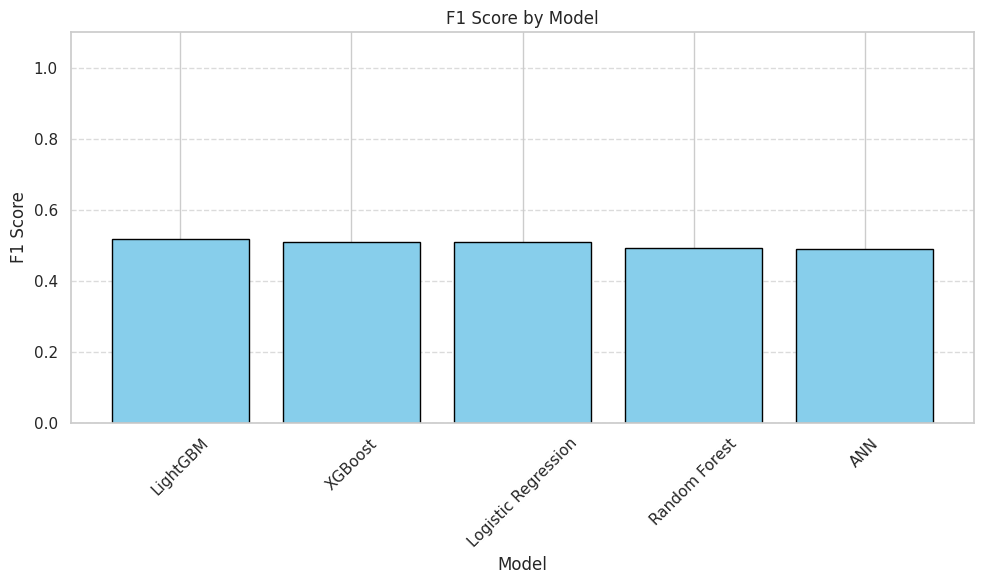

In [ ]:
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Prepare results dictionary
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC-ROC': [],
    'Training Time (s)': [],
    'Inference Time (s)': []
}

# Loop through models and evaluate
for name, model in models.items():
    print(f"\nTraining and evaluating: {name}")

    # Train
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    # Predict
    start_infer = time.time()
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred
    end_infer = time.time()

    # Metrics
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['AUC-ROC'].append(roc_auc_score(y_test, y_proba))
    results['Training Time (s)'].append(end_train - start_train)
    results['Inference Time (s)'].append(end_infer - start_infer)

# Display as DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("\n✅ Model Performance Comparison:")
display(results_df.reset_index(drop=True))

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['F1 Score'], color='skyblue', edgecolor='black')

plt.title('F1 Score by Model')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# **LSTM** **with** **transformer**

In [ ]:

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model

# Define a function to build the LSTM + Transformer model
def build_lstm_transformer(input_shape, n_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM Layer for sequence learning
    lstm = LSTM(64, return_sequences=True)(inputs)

    # Transformer Block
    transformer_input = LayerNormalization()(lstm)
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(transformer_input, transformer_input)
    attention = Dropout(0.1)(attention)
    attention_output = LayerNormalization()(attention)

    # Fully Connected layer for classification
    lstm_transformer_output = Dense(128, activation='relu')(attention_output)
    lstm_transformer_output = Dropout(0.2)(lstm_transformer_output)
    lstm_transformer_output = Dense(n_classes, activation='softmax')(lstm_transformer_output)

    # Model
    model = Model(inputs=inputs, outputs=lstm_transformer_output)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], 1)  # Shape should be (timesteps, features) for LSTM
n_classes = len(np.unique(y_train))  # Number of output classes

# Build the LSTM + Transformer model
model = build_lstm_transformer(input_shape, n_classes)

# Model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 53, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 53, 64)    │     16,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 53, 64)    │        128 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 53, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 53, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 53, 64)    │        128 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 53, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 53, 128)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 53, 2)     │        258 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,098 (359.76 KB)

 Trainable params: 92,098 (359.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1: Train Loss = 0.7163, Accuracy = 0.4675
Epoch 2: Train Loss = 0.6975, Accuracy = 0.4900
Epoch 3: Train Loss = 0.6968, Accuracy = 0.4975
Epoch 4: Train Loss = 0.6939, Accuracy = 0.4788
Epoch 5: Train Loss = 0.6967, Accuracy = 0.5000
Epoch 6: Train Loss = 0.6969, Accuracy = 0.4913
Epoch 7: Train Loss = 0.6842, Accuracy = 0.5650
Epoch 8: Train Loss = 0.6807, Accuracy = 0.5825
Epoch 9: Train Loss = 0.6707, Accuracy = 0.5875
Epoch 10: Train Loss = 0.6680, Accuracy = 0.6050
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.64      0.57        97
           1       0.57      0.45      0.50       103

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.55      0.54      0.54       200

AUC-ROC: 0.5693
Accuracy: 0.5400


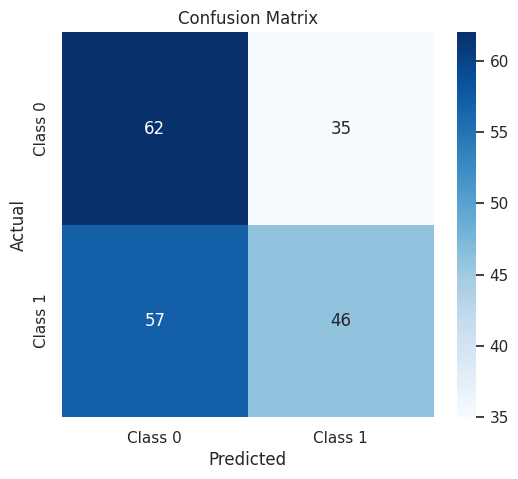

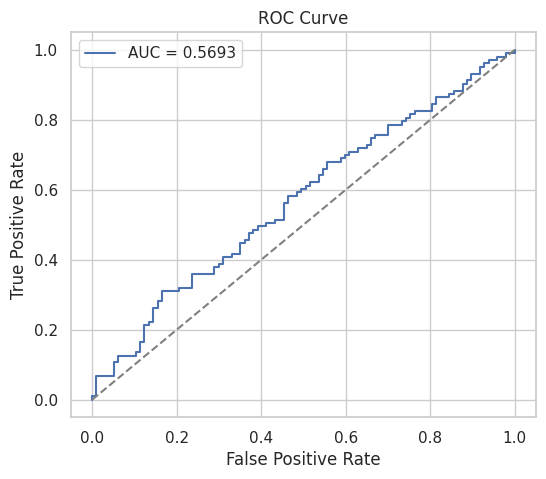

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
SEQ_LEN = 50
INPUT_DIM = 16
HIDDEN_DIM = 64
N_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 10

# Dummy data
X = torch.randn(1000, SEQ_LEN, INPUT_DIM)
y = torch.randint(0, N_CLASSES, (1000,))

# Dataset and Dataloader
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


# Model
class LSTMTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMTransformerModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim * 2, nhead=4, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch, seq, hidden*2]
        transformer_out = self.transformer(lstm_out.permute(1, 0, 2))  # [seq, batch, hidden*2]
        out = transformer_out.mean(dim=0)  # global average pooling
        return self.classifier(out)


# Initialize
model = LSTMTransformerModel(INPUT_DIM, HIDDEN_DIM, N_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Training
def train(model, loader):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu())
        all_labels.extend(y_batch.cpu())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


# Evaluation + Visualization
def evaluate_and_visualize(model, loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu()
            preds = outputs.argmax(dim=1).cpu()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print("Classification Report:\n", report)
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


# Train & Evaluate
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

# Final Evaluation
evaluate_and_visualize(model, val_loader)
